In [107]:
import numpy as np
import pandas as pd
from os import listdir
import random
from nltk import ngrams
import spacy
import string
import pickle as pkl
from collections import Counter
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

In [2]:
def load_doc(filename):
    file = open(filename,'r')
    text = file.read()
    file.close()
    return text

In [3]:
def process_data(t_directory):
    s_type = ['neg','pos']
    data = []
    target = []
    ratings = []
    for i,s in enumerate(s_type):
        directory = t_directory+'/'+s_type[i]
        for filename in listdir(directory):
            if not filename.endswith('.txt'):
                continue
            path = directory + '/' + filename
            rating = int(filename.split('.')[0].split('_')[-1])
            text = load_doc(path)
            data.append(text)
            target.append(i)
            ratings.append(rating)
            #print('Loaded {}'.format(filename))
    print('Loaded {} data'.format(t_directory))
    return np.array(data), np.array(target), np.array(ratings)
            

In [4]:
train_directory = 'aclImdb/train'
test_directory = 'aclImdb/test'

In [5]:
train_val_data,train_val_target, train_val_ratings = process_data(train_directory)
test_data,test_target, test_ratings = process_data(test_directory)


Loaded aclImdb/train data
Loaded aclImdb/test data


In [7]:
indices = np.arange(train_val_data.shape[0])
np.random.shuffle(indices)

In [8]:
train_val_data = train_val_data[indices]
train_val_ratings = train_val_ratings[indices]
train_val_target = train_val_target[indices]

In [9]:
train_data = train_val_data[:20000]
train_ratings = train_val_ratings[:20000]
train_target = train_val_target[:20000]

val_data = train_val_data[20000:]
val_ratings = train_val_ratings[20000:]
val_target = train_val_target[20000:]

In [60]:
pkl.dump(train_data,open('train_data.p','wb'))
pkl.dump(train_ratings,open('train_ratings.p','wb'))
pkl.dump(train_target,open('train_target.p','wb'))

pkl.dump(val_data,open('val_data.p','wb'))
pkl.dump(val_ratings,open('val_ratings.p','wb'))
pkl.dump(val_target,open('val_target.p','wb'))

pkl.dump(test_data,open('test_data.p','wb'))
pkl.dump(test_ratings,open('test_ratings.p','wb'))
pkl.dump(test_target,open('test_target.p','wb'))


In [127]:
from spacy.lang.en.stop_words import STOP_WORDS

In [129]:
# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent):
  tokens = tokenizer(sent)
  return [token.text.lower() for token in tokens if ((token.text not in punctuations) and (token.text not in STOP_WORDS))]

def lower_case_remove_punc(parsed):
    return [token.text.lower() for token in parsed if ((token.text not in punctuations) and (token.text not in STOP_WORDS))]


def get_ngrams(text, n):
    all_grams = []
    for i in range(2,n+1):
        n_grams = ngrams(text, i)
        n_grams = [' '.join(grams) for grams in n_grams]
        all_grams += n_grams
    return text+all_grams

def process_sent_grams(sent,n):
    tokens = lower_case_remove_punc(sent)
    tokens = get_ngrams(tokens,n)
    return tokens

# Example
tokens = tokenize(u'Apple is looking at buying U.K. startup for $1 billion')
temp = get_ngrams(tokens,3)
#tokens = process_sent_grams(u'Apple is looking at buying U.K. startup for $1 billion',3)
#print (tokens)
#print(temp)

In [133]:
type(val_data.tolist()[0])

str

In [224]:

def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []

    for sample in tokenizer.pipe(dataset, disable=['parser', 'tagger', 'ner'], batch_size=512, n_threads=-1):
        tokens = process_sent_grams(sample,4)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

# val set tokens
print ("Tokenizing val data")
val_data_tokens, _ = tokenize_dataset(val_data.tolist())
pkl.dump(val_data_tokens, open("val_data_tokens_grams_4_no_sw.p", "wb"))

# test set tokens
print ("Tokenizing test data")
test_data_tokens, _ = tokenize_dataset(test_data.tolist())
pkl.dump(test_data_tokens, open("test_data_tokens_grams_4_no_sw.p", "wb"))

# train set tokens
print ("Tokenizing train data")
train_data_tokens, all_train_tokens = tokenize_dataset(train_data.tolist())
pkl.dump(train_data_tokens, open("train_data_tokens_grams_4_no_sw.p", "wb"))
pkl.dump(all_train_tokens, open("all_train_tokens_grams_4_no_sw.p", "wb"))

Tokenizing val data
Tokenizing test data
Tokenizing train data


In [197]:
train_data_tokens = pkl.load(open("pickles/train_data_tokens_grams_3_no_sw.p", "rb"))
all_train_tokens = pkl.load(open("pickles/all_train_tokens_grams_3_no_sw.p", "rb"))

val_data_tokens = pkl.load(open("pickles/val_data_tokens_grams_3_no_sw.p", "rb"))
test_data_tokens = pkl.load(open("pickles/test_data_tokens_grams_3_no_sw.p", "rb"))

# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 7542090


In [198]:
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens,max_vocab_size):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

In [199]:
VOCAB_SIZE = 100000
token2id, id2token = build_vocab(all_train_tokens,VOCAB_SIZE)

In [200]:
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 56862 ; token tells people
Token tells people; token id 56862


In [201]:
# convert token to id in the dataset
def token2index_dataset(tokens_data,token2id,id2token):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

In [202]:
train_data_indices = token2index_dataset(train_data_tokens,token2id,id2token)
val_data_indices = token2index_dataset(val_data_tokens,token2id,id2token)
test_data_indices = token2index_dataset(test_data_tokens,token2id,id2token)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [203]:
MAX_SENTENCE_LENGTH = 200


class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

In [204]:
# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 64
train_dataset = NewsGroupDataset(train_data_indices, train_target)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data_indices, val_target)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data_indices, test_target)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

#for i, (data, lengths, labels) in enumerate(train_loader):
#    print (data)
#    print (labels)
#    break

In [205]:
class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim,out_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,out_dim)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

In [209]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [206]:
emb_dim = 256
out_dim = 2
model = BagOfWords(len(id2token), emb_dim,out_dim).to(DEVICE)

In [207]:
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [210]:
learning_rate = 0.001
num_epochs = 20 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#Added Scheduler, comment this for removing it
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma=0.9)


train_loss_history = []
val_acc_history = []
for epoch in range(num_epochs):
    scheduler.step()
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data.to(DEVICE), lengths.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch).to(DEVICE)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        train_loss_history.append(loss.item())
        # validate every 100 iterations
        if i > 0 and i % 25 == 0:
            # validate
            print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), loss.item()))
    
    val_acc = test_model(val_loader, model)
    val_acc_history.append(val_acc)
    print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))

    

val_acc_history = np.array(val_acc_history)
max_val_acc = np.max(val_acc_history)
max_val_acc_epoch = np.argmax(val_acc_history)

Epoch: [1/20], Step: [26/313], Train Loss: 0.7287982106208801
Epoch: [1/20], Step: [51/313], Train Loss: 0.6964669227600098
Epoch: [1/20], Step: [76/313], Train Loss: 0.6710790395736694
Epoch: [1/20], Step: [101/313], Train Loss: 0.6899941563606262
Epoch: [1/20], Step: [126/313], Train Loss: 0.6461683511734009
Epoch: [1/20], Step: [151/313], Train Loss: 0.6364166140556335
Epoch: [1/20], Step: [176/313], Train Loss: 0.6307958364486694
Epoch: [1/20], Step: [201/313], Train Loss: 0.6228609085083008
Epoch: [1/20], Step: [226/313], Train Loss: 0.6103930473327637
Epoch: [1/20], Step: [251/313], Train Loss: 0.5925058126449585
Epoch: [1/20], Step: [276/313], Train Loss: 0.5768373012542725
Epoch: [1/20], Step: [301/313], Train Loss: 0.5361719131469727
Epoch: [1/20], Step: [313/313], Validation Acc: 81.44
Epoch: [2/20], Step: [26/313], Train Loss: 0.48192688822746277
Epoch: [2/20], Step: [51/313], Train Loss: 0.5560431480407715
Epoch: [2/20], Step: [76/313], Train Loss: 0.4662078619003296
Epoch:

Epoch: [11/20], Step: [51/313], Train Loss: 0.07904742658138275
Epoch: [11/20], Step: [76/313], Train Loss: 0.06379777938127518
Epoch: [11/20], Step: [101/313], Train Loss: 0.0412013866007328
Epoch: [11/20], Step: [126/313], Train Loss: 0.06147509068250656
Epoch: [11/20], Step: [151/313], Train Loss: 0.05527174472808838
Epoch: [11/20], Step: [176/313], Train Loss: 0.03141302987933159
Epoch: [11/20], Step: [201/313], Train Loss: 0.05131310969591141
Epoch: [11/20], Step: [226/313], Train Loss: 0.034499507397413254
Epoch: [11/20], Step: [251/313], Train Loss: 0.05969845876097679
Epoch: [11/20], Step: [276/313], Train Loss: 0.0496627576649189
Epoch: [11/20], Step: [301/313], Train Loss: 0.053612690418958664
Epoch: [11/20], Step: [313/313], Validation Acc: 89.5
Epoch: [12/20], Step: [26/313], Train Loss: 0.044804610311985016
Epoch: [12/20], Step: [51/313], Train Loss: 0.03476184606552124
Epoch: [12/20], Step: [76/313], Train Loss: 0.08078013360500336
Epoch: [12/20], Step: [101/313], Train L

Epoch: [20/20], Step: [313/313], Validation Acc: 89.42


In [211]:
max_val_acc

89.58

In [221]:
pkl.dump(train_loss_history,open('pickles/train_loss_history_no_sw_aneal.p','wb'))
pkl.dump(val_acc_history,open('pickles/val_acc_history_no_sw_aneal.p','wb'))

In [162]:
import matplotlib.pyplot as plt
%matplotlib inline

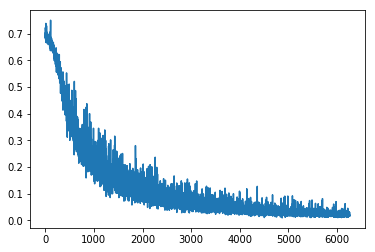

In [213]:
plt.plot(range(len(train_loss_history)),train_loss_history)

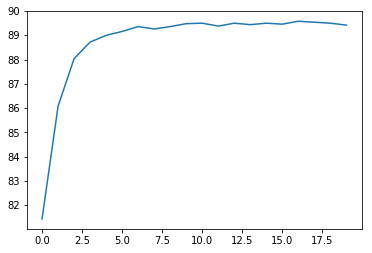

In [214]:
plt.plot(range(val_acc_history.shape[0]),val_acc_history)

In [161]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
#print ("Test Acc {}".format(test_model(test_loader, model)))

After training for 20 epochs
Val Acc 89.3


In [120]:
lrs = [0.01,0.001]
num_grams = [1,2,3,4]
vocab_sizes = [10000,20000,50000,100000]
emb_dims = [100,256]
optims = ['adam','sgd']
somelists = [optims,lrs,num_grams,vocab_sizes,emb_dims]

In [121]:
result = list(itertools.product(*somelists))

In [122]:
df_param = pd.DataFrame(result,columns=['optimizer','lrs','num_grams','vocab_sizes','emb_dims'])

In [123]:
df_param['train_loss'] = None

df_param['val_accs'] = None

df_param['best_val_acc'] = None
df_param['epoch_best_acc'] = None

In [225]:
result_df = pkl.load(open('result_df_no_sw.pkl','rb'))

In [226]:
result_df.loc[result_df['best_val_acc'] == result_df['best_val_acc'].max()].iloc[0]

batch_size                                                       64
optimizer                                                      adam
lrs                                                           0.001
num_grams                                                         3
vocab_sizes                                                  100000
emb_dims                                                        100
train_loss        [0.6968493461608887, 0.6881409287452698, 0.700...
val_accs          [78.28, 84.66, 86.94, 88.16, 88.54, 89.12, 89....
best_val_acc                                                  90.08
epoch_best_acc                                                   13
Name: 54, dtype: object

## Changing just the n-grams

In [234]:
results_ngrams = result_df[(result_df['batch_size'] == 64) & (result_df['optimizer'] == 'adam') & (result_df['lrs'] == 0.001) & (result_df['vocab_sizes'] == 100000) & (result_df['emb_dims'] == 100)]

In [237]:
results_ngrams

,batch_size,optimizer,lrs,num_grams,vocab_sizes,emb_dims,train_loss,val_accs,best_val_acc,epoch_best_acc
38,64,adam,0.001,1,100000,100,"[0.7049619555473328, 0.7090957164764404, 0.694...","[80.54, 85.34, 87.32, 88.0, 88.36, 88.64, 88.8...",88.9,9
46,64,adam,0.001,2,100000,100,"[0.7063122987747192, 0.6899181008338928, 0.713...","[79.6, 84.9, 87.46, 88.32, 88.94, 89.32, 89.48...",89.6,10
54,64,adam,0.001,3,100000,100,"[0.6968493461608887, 0.6881409287452698, 0.700...","[78.28, 84.66, 86.94, 88.16, 88.54, 89.12, 89....",90.08,13
62,64,adam,0.001,4,100000,100,"[0.7305366396903992, 0.7144002318382263, 0.687...","[77.9, 84.52, 86.66, 87.68, 88.72, 88.8, 89.12...",89.38,16


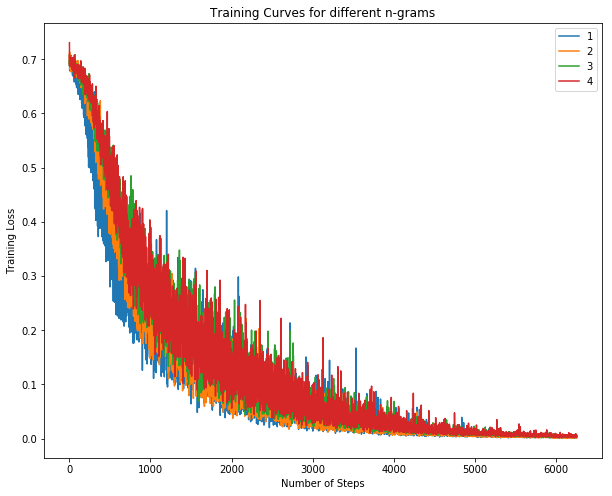

In [252]:
plt.figure(figsize=(10,8))

for i in range(len(results_ngrams)):
    plt.plot(range(len(results_ngrams.iloc[i]['train_loss'])),results_ngrams.iloc[i]['train_loss'],label=str(results_ngrams.iloc[i]['num_grams']))
    

plt.legend()
plt.xlabel('Number of Steps')
plt.ylabel('Training Loss')
plt.title('Training Curves for different n-grams')
plt.savefig('plots/training_curve_n-gram.png')

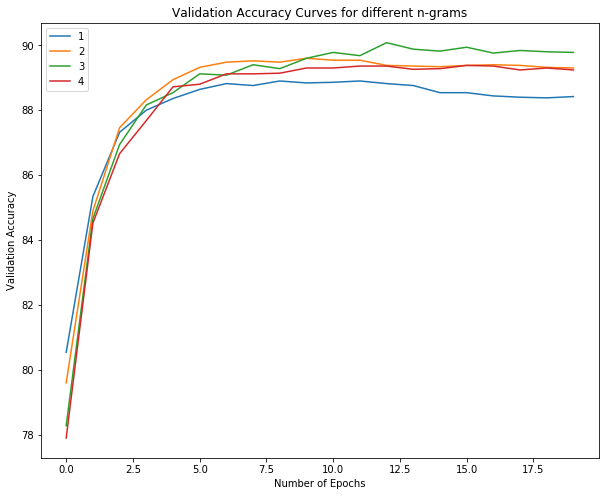

In [253]:
plt.figure(figsize=(10,8))

for i in range(len(results_ngrams)):
    plt.plot(range(len(results_ngrams.iloc[i]['val_accs'])),results_ngrams.iloc[i]['val_accs'],label=str(results_ngrams.iloc[i]['num_grams']))
    

plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Curves for different n-grams')
plt.savefig('plots/accuracy_n-gram.png')

In [250]:
print(results_ngrams[['batch_size', 'optimizer', 'lrs', 'num_grams', 'vocab_sizes',
       'emb_dims', 'best_val_acc', 'epoch_best_acc']].to_latex(index=False))

\begin{tabular}{rlrrrrll}
\toprule
 batch\_size & optimizer &    lrs &  num\_grams &  vocab\_sizes &  emb\_dims & best\_val\_acc & epoch\_best\_acc \\
\midrule
         64 &      adam &  0.001 &          1 &       100000 &       100 &         88.9 &              9 \\
         64 &      adam &  0.001 &          2 &       100000 &       100 &         89.6 &             10 \\
         64 &      adam &  0.001 &          3 &       100000 &       100 &        90.08 &             13 \\
         64 &      adam &  0.001 &          4 &       100000 &       100 &        89.38 &             16 \\
\bottomrule
\end{tabular}



## Changing just the embed dimensions

In [254]:
results_embed = result_df[(result_df['batch_size'] == 64) & (result_df['optimizer'] == 'adam') & (result_df['lrs'] == 0.001) & (result_df['vocab_sizes'] == 100000) & (result_df['num_grams'] == 3)]

In [255]:
results_embed

,batch_size,optimizer,lrs,num_grams,vocab_sizes,emb_dims,train_loss,val_accs,best_val_acc,epoch_best_acc
54,64,adam,0.001,3,100000,100,"[0.6968493461608887, 0.6881409287452698, 0.700...","[78.28, 84.66, 86.94, 88.16, 88.54, 89.12, 89....",90.08,13
55,64,adam,0.001,3,100000,256,"[0.7069001793861389, 0.6987022161483765, 0.701...","[81.82, 85.66, 88.12, 88.76, 89.36, 89.48, 89....",89.52,10


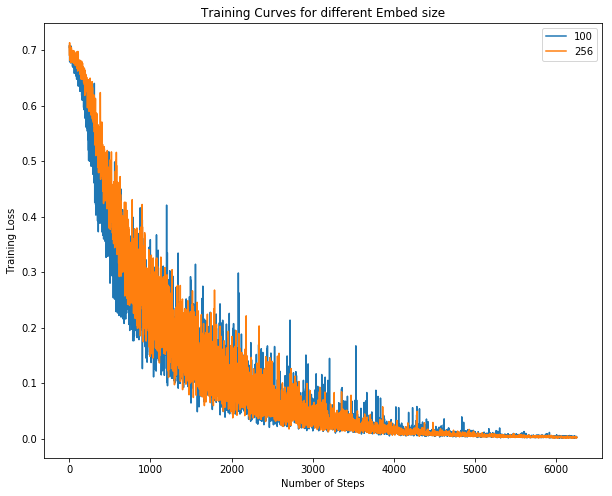

In [259]:
plt.figure(figsize=(10,8))

for i in range(len(results_embed)):
    plt.plot(range(len(results_embed.iloc[i]['train_loss'])),results_ngrams.iloc[i]['train_loss'],label=str(results_embed.iloc[i]['emb_dims']))
    

plt.legend()
plt.xlabel('Number of Steps')
plt.ylabel('Training Loss')
plt.title('Training Curves for different Embed size')
plt.savefig('plots/training_curve_embed.png')

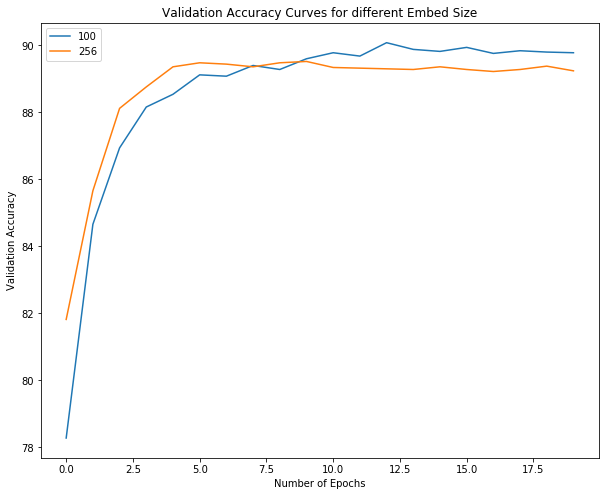

In [265]:
plt.figure(figsize=(10,8))

for i in range(len(results_embed)):
    plt.plot(range(len(results_embed.iloc[i]['val_accs'])),results_embed.iloc[i]['val_accs'],label=str(results_embed.iloc[i]['emb_dims']))
    

plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Curves for different Embed Size')
plt.savefig('plots/accuracy_embed.png')

In [261]:
print(results_embed[['batch_size', 'optimizer', 'lrs', 'num_grams', 'vocab_sizes',
       'emb_dims', 'best_val_acc', 'epoch_best_acc']].to_latex(index=False))

\begin{tabular}{rlrrrrll}
\toprule
 batch\_size & optimizer &    lrs &  num\_grams &  vocab\_sizes &  emb\_dims & best\_val\_acc & epoch\_best\_acc \\
\midrule
         64 &      adam &  0.001 &          3 &       100000 &       100 &        90.08 &             13 \\
         64 &      adam &  0.001 &          3 &       100000 &       256 &        89.52 &             10 \\
\bottomrule
\end{tabular}



## Changing just the vocab size

In [262]:
results_vocab_sizes = result_df[(result_df['batch_size'] == 64) & (result_df['optimizer'] == 'adam') & (result_df['lrs'] == 0.001) & (result_df['emb_dims'] == 100) & (result_df['num_grams'] == 3)]

In [263]:
results_vocab_sizes

,batch_size,optimizer,lrs,num_grams,vocab_sizes,emb_dims,train_loss,val_accs,best_val_acc,epoch_best_acc
48,64,adam,0.001,3,10000,100,"[0.6915798187255859, 0.6925765872001648, 0.692...","[72.64, 83.26, 85.56, 86.5, 87.06, 87.56, 87.6...",88.6,11
50,64,adam,0.001,3,20000,100,"[0.7010214924812317, 0.6937382817268372, 0.697...","[79.0, 84.34, 86.22, 87.66, 88.34, 88.72, 88.9...",89.04,9
52,64,adam,0.001,3,50000,100,"[0.6977759003639221, 0.6942582130432129, 0.693...","[74.5, 84.12, 86.1, 87.78, 88.14, 88.82, 89.14...",89.48,12
54,64,adam,0.001,3,100000,100,"[0.6968493461608887, 0.6881409287452698, 0.700...","[78.28, 84.66, 86.94, 88.16, 88.54, 89.12, 89....",90.08,13


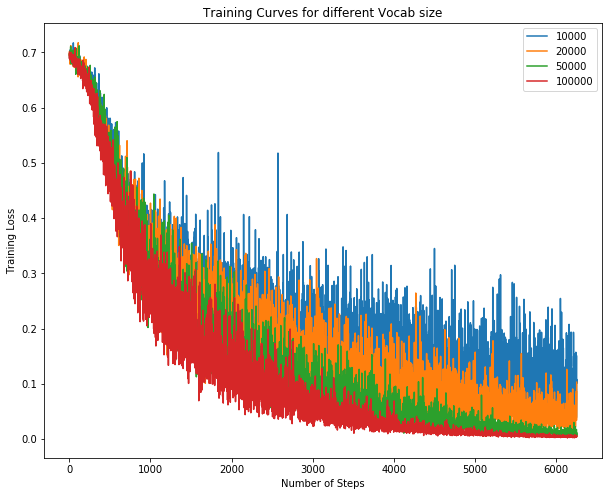

In [264]:
plt.figure(figsize=(10,8))

for i in range(len(results_vocab_sizes)):
    plt.plot(range(len(results_vocab_sizes.iloc[i]['train_loss'])),results_vocab_sizes.iloc[i]['train_loss'],label=str(results_vocab_sizes.iloc[i]['vocab_sizes']))
    

plt.legend()
plt.xlabel('Number of Steps')
plt.ylabel('Training Loss')
plt.title('Training Curves for different Vocab size')
plt.savefig('plots/training_curve_vocab.png')

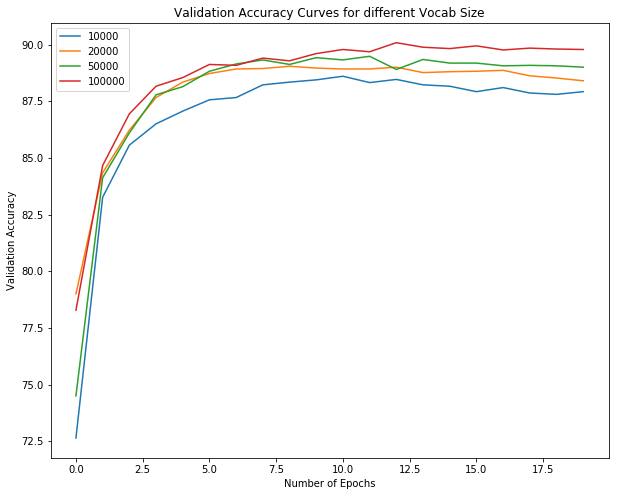

In [266]:
plt.figure(figsize=(10,8))

for i in range(len(results_vocab_sizes)):
    plt.plot(range(len(results_vocab_sizes.iloc[i]['val_accs'])),results_vocab_sizes.iloc[i]['val_accs'],label=str(results_vocab_sizes.iloc[i]['vocab_sizes']))
    

plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Curves for different Vocab Size')
plt.savefig('plots/accuracy_vocab.png')

In [267]:
print(results_vocab_sizes[['batch_size', 'optimizer', 'lrs', 'num_grams', 'vocab_sizes',
       'emb_dims', 'best_val_acc', 'epoch_best_acc']].to_latex(index=False))

\begin{tabular}{rlrrrrll}
\toprule
 batch\_size & optimizer &    lrs &  num\_grams &  vocab\_sizes &  emb\_dims & best\_val\_acc & epoch\_best\_acc \\
\midrule
         64 &      adam &  0.001 &          3 &        10000 &       100 &         88.6 &             11 \\
         64 &      adam &  0.001 &          3 &        20000 &       100 &        89.04 &              9 \\
         64 &      adam &  0.001 &          3 &        50000 &       100 &        89.48 &             12 \\
         64 &      adam &  0.001 &          3 &       100000 &       100 &        90.08 &             13 \\
\bottomrule
\end{tabular}



## Changing just the LR

In [268]:
results_lrs = result_df[(result_df['batch_size'] == 64) & (result_df['optimizer'] == 'adam') & (result_df['vocab_sizes'] == 100000) & (result_df['emb_dims'] == 100) & (result_df['num_grams'] == 3)]

In [269]:
results_lrs

,batch_size,optimizer,lrs,num_grams,vocab_sizes,emb_dims,train_loss,val_accs,best_val_acc,epoch_best_acc
22,64,adam,0.010,3,100000,100,"[0.6919881701469421, 0.7010348439216614, 0.700...","[89.4, 89.02, 88.4, 88.82, 88.92, 88.86, 88.8,...",89.4,1
54,64,adam,0.001,3,100000,100,"[0.6968493461608887, 0.6881409287452698, 0.700...","[78.28, 84.66, 86.94, 88.16, 88.54, 89.12, 89....",90.08,13


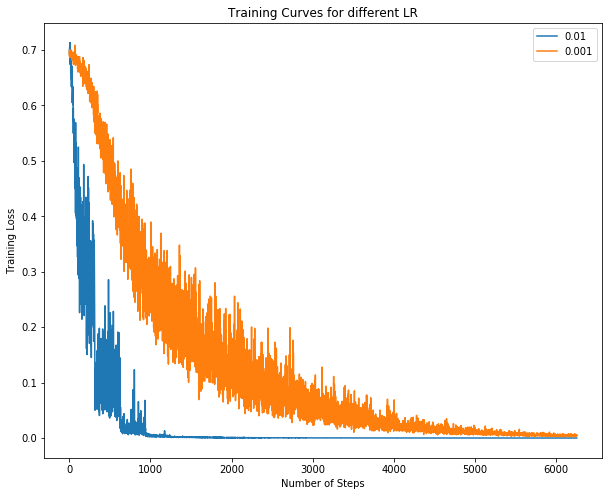

In [270]:
plt.figure(figsize=(10,8))

for i in range(len(results_lrs)):
    plt.plot(range(len(results_lrs.iloc[i]['train_loss'])),results_lrs.iloc[i]['train_loss'],label=str(results_lrs.iloc[i]['lrs']))
    

plt.legend()
plt.xlabel('Number of Steps')
plt.ylabel('Training Loss')
plt.title('Training Curves for different LR')
plt.savefig('plots/training_curve_lr.png')

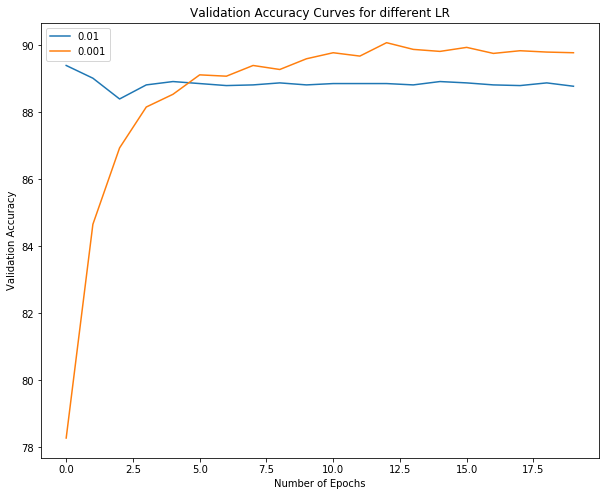

In [271]:
plt.figure(figsize=(10,8))

for i in range(len(results_lrs)):
    plt.plot(range(len(results_lrs.iloc[i]['val_accs'])),results_lrs.iloc[i]['val_accs'],label=str(results_lrs.iloc[i]['lrs']))
    

plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Curves for different LR')
plt.savefig('plots/accuracy_lr.png')

In [272]:
print(results_lrs[['batch_size', 'optimizer', 'lrs', 'num_grams', 'vocab_sizes',
       'emb_dims', 'best_val_acc', 'epoch_best_acc']].to_latex(index=False))

\begin{tabular}{rlrrrrll}
\toprule
 batch\_size & optimizer &    lrs &  num\_grams &  vocab\_sizes &  emb\_dims & best\_val\_acc & epoch\_best\_acc \\
\midrule
         64 &      adam &  0.010 &          3 &       100000 &       100 &         89.4 &              1 \\
         64 &      adam &  0.001 &          3 &       100000 &       100 &        90.08 &             13 \\
\bottomrule
\end{tabular}



## Changing just the optimizer

In [273]:
results_optimizer = result_df[(result_df['batch_size'] == 64) & (result_df['lrs'] == 0.001) & (result_df['vocab_sizes'] == 100000) & (result_df['emb_dims'] == 100) & (result_df['num_grams'] == 3)]

In [274]:
results_optimizer

,batch_size,optimizer,lrs,num_grams,vocab_sizes,emb_dims,train_loss,val_accs,best_val_acc,epoch_best_acc
54,64,adam,0.001,3,100000,100,"[0.6968493461608887, 0.6881409287452698, 0.700...","[78.28, 84.66, 86.94, 88.16, 88.54, 89.12, 89....",90.08,13
118,64,sgd,0.001,3,100000,100,"[0.7020208239555359, 0.6868180632591248, 0.704...","[49.32, 49.92, 50.08, 50.48, 50.68, 50.96, 51....",55.58,20


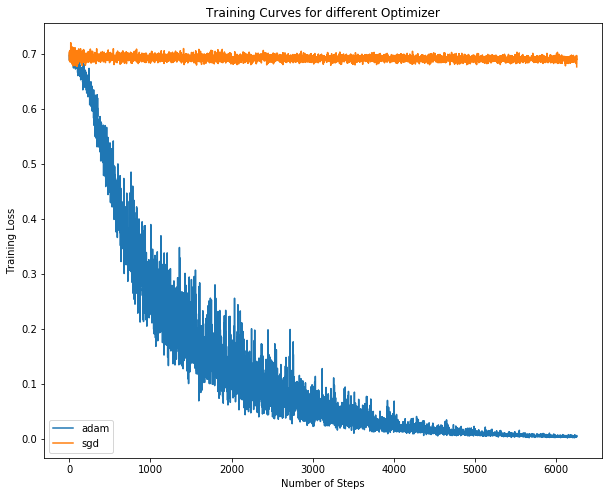

In [275]:
plt.figure(figsize=(10,8))

for i in range(len(results_optimizer)):
    plt.plot(range(len(results_optimizer.iloc[i]['train_loss'])),results_optimizer.iloc[i]['train_loss'],label=str(results_optimizer.iloc[i]['optimizer']))
    

plt.legend()
plt.xlabel('Number of Steps')
plt.ylabel('Training Loss')
plt.title('Training Curves for different Optimizer')
plt.savefig('plots/training_curve_opimizer.png')

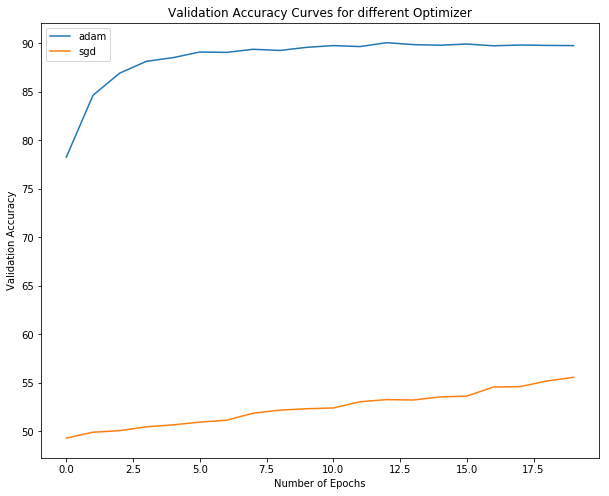

In [276]:
plt.figure(figsize=(10,8))

for i in range(len(results_optimizer)):
    plt.plot(range(len(results_optimizer.iloc[i]['val_accs'])),results_optimizer.iloc[i]['val_accs'],label=str(results_optimizer.iloc[i]['optimizer']))
    

plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Curves for different Optimizer')
plt.savefig('plots/accuracy_optimizer.png')

In [277]:
print(results_optimizer[['batch_size', 'optimizer', 'lrs', 'num_grams', 'vocab_sizes',
       'emb_dims', 'best_val_acc', 'epoch_best_acc']].to_latex(index=False))

\begin{tabular}{rlrrrrll}
\toprule
 batch\_size & optimizer &    lrs &  num\_grams &  vocab\_sizes &  emb\_dims & best\_val\_acc & epoch\_best\_acc \\
\midrule
         64 &      adam &  0.001 &          3 &       100000 &       100 &        90.08 &             13 \\
         64 &       sgd &  0.001 &          3 &       100000 &       100 &        55.58 &             20 \\
\bottomrule
\end{tabular}



## Effect of different tokenization schemes

In [279]:
train_loss_history_no_sw = pkl.load(open('pickles/train_loss_history_no_sw.p','rb'))
train_loss_history_w_sw = pkl.load(open('pickles/train_loss_history_w_sw.p','rb'))

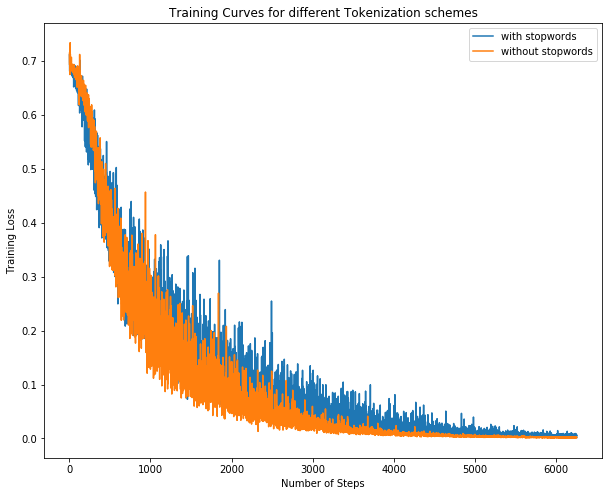

In [281]:
plt.figure(figsize=(10,8))
plt.plot(range(len(train_loss_history_w_sw)),train_loss_history_w_sw,label='with stopwords')
plt.plot(range(len(train_loss_history_no_sw)),train_loss_history_no_sw,label='without stopwords')
plt.legend()
plt.xlabel('Number of Steps')
plt.ylabel('Training Loss')
plt.title('Training Curves for different Tokenization schemes')
plt.savefig('plots/training_curve_token.png')

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(range(len(train_loss_history_w_sw)),train_loss_history_w_sw,label='with stopwords')
plt.plot(range(len(train_loss_history_no_sw)),train_loss_history_no_sw,label='without stopwords')
plt.legend()
plt.xlabel('Number of Steps')
plt.ylabel('Training Loss')
plt.title('Training Curves for different Tokenization schemes')
plt.savefig('plots/training_curve_token.png')

In [282]:
val_acc_history_no_sw = pkl.load(open('pickles/val_acc_history_no_sw.p','rb'))
val_acc_history_w_sw = pkl.load(open('pickles/val_acc_history_w_sw.p','rb'))

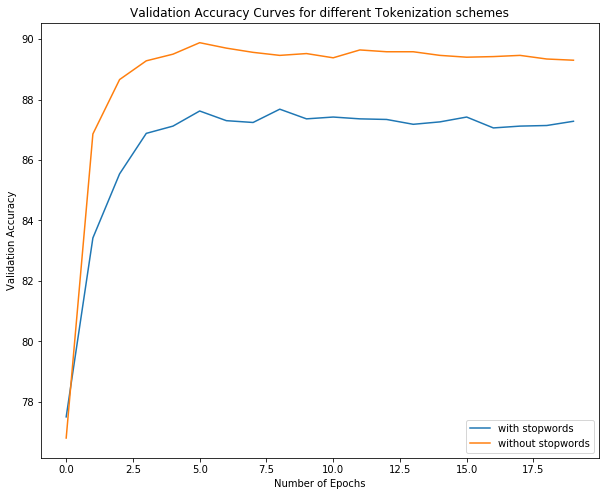

In [283]:
plt.figure(figsize=(10,8))
plt.plot(range(len(val_acc_history_w_sw)),val_acc_history_w_sw,label='with stopwords')
plt.plot(range(len(val_acc_history_no_sw)),val_acc_history_no_sw,label='without stopwords')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Curves for different Tokenization schemes')
plt.savefig('plots/accuracy_token.png')

## Effect of Annealing using lr_scheduler

In [285]:
train_loss_history_no_sw_aneal = pkl.load(open('pickles/train_loss_history_no_sw_aneal.p','rb'))
val_acc_history_no_sw_aneal = pkl.load(open('pickles/val_acc_history_no_sw_aneal.p','rb'))

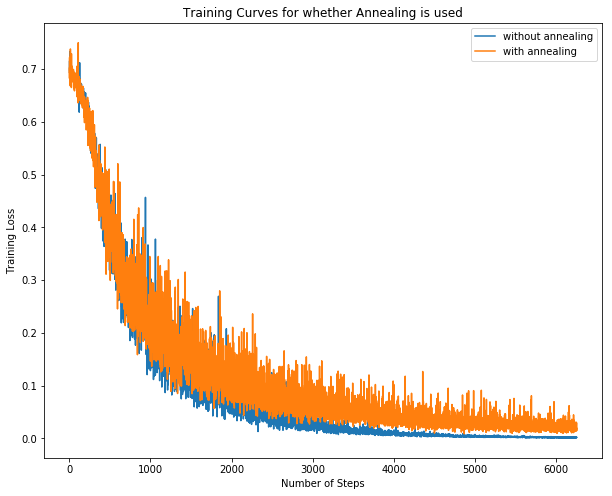

In [286]:
plt.figure(figsize=(10,8))
plt.plot(range(len(train_loss_history_no_sw)),train_loss_history_no_sw,label='without annealing')
plt.plot(range(len(train_loss_history_no_sw_aneal)),train_loss_history_no_sw_aneal,label='with annealing')
plt.legend()
plt.xlabel('Number of Steps')
plt.ylabel('Training Loss')
plt.title('Training Curves for whether Annealing is used')
plt.savefig('plots/training_curve_anneal.png')

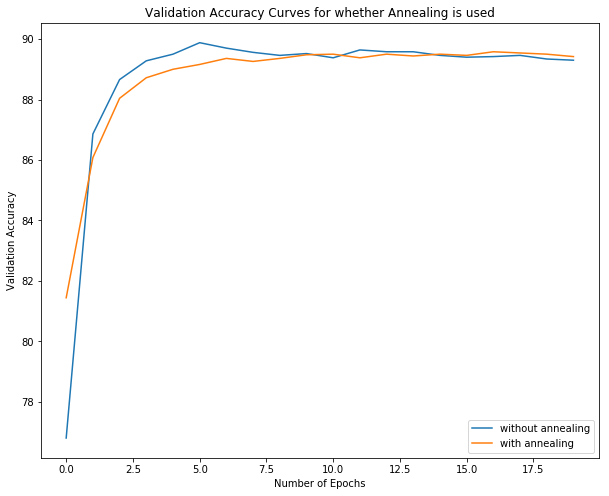

In [287]:
plt.figure(figsize=(10,8))
plt.plot(range(len(val_acc_history_no_sw)),val_acc_history_no_sw,label='without annealing')
plt.plot(range(len(val_acc_history_no_sw_aneal)),val_acc_history_no_sw_aneal,label='with annealing')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Curves for whether Annealing is used')
plt.savefig('plots/accuracy_aneal.png')